# In this notebook
I demonstrate the calculations required for looking at direct and indirect effects.

In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
from scipy.signal import convolve2d

Calculate the direct effect by iterating over the coefficients for the direct effect, and multiplying it by the standard deviation to get a bootstrapped estimate of the direct effect.

In [132]:
df = pd.read_csv(os.path.join('../results/cv', "f19", "results.csv"))
df = df[df['iter'] > 5]
df = df[df['ndvi_ls'] == 15]
df = df[df['albedo_ls'] == 11]
df = df[df['fold']==3]
df['beta_18'].mean()

-0.45783047320447534

# Street Trees Intervention

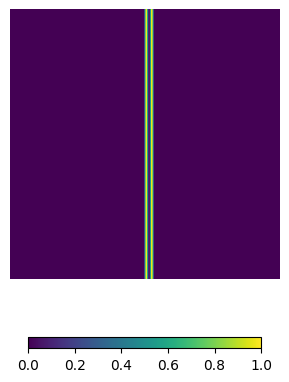

In [65]:
# Let's visualize the intervention

def make_street_trees():
    treatment = np.zeros((100, 100))
    treatment[:, 50] = 1
    treatment[:, 52] = 1
    return treatment

street_trees = make_street_trees()

def plot_intervention(intervention):
    fig, ax = plt.subplots(figsize=(5,5))
    img = ax.imshow(intervention)
    ax.axis('off')
    fig.colorbar(img, orientation='horizontal', shrink=0.6)
    plt.show()

plot_intervention(street_trees)

In [130]:
# Calculate direct effect
def calc_direct_effect(treatment, coef, coef_std):
    return treatment*df[coef].mean()

# Calculate indirect effect
def calc_indirect_effect(treatment, length_scale, coef, coef_std):
    window_size = 25
    dist_matrix = np.sqrt(
            np.arange(-window_size, window_size + 1)[np.newaxis, :] ** 2
            + np.arange(-window_size, window_size + 1)[:, np.newaxis] ** 2
        )

    weight_matrix = np.exp(-dist_matrix / length_scale)
    weight_matrix[window_size, window_size] = 0
    weight_matrix /= weight_matrix.sum()

    output = convolve2d(treatment, weight_matrix , mode="same")
    # print(np.unique(output))
    # print(df[coef].mean())
    return output*df[coef].mean()

def calc_overall(de, ie):
    return de + ie

<>:22: SyntaxWarning: invalid escape sequence '\D'
<>:23: SyntaxWarning: invalid escape sequence '\D'
<>:38: SyntaxWarning: invalid escape sequence '\D'
<>:22: SyntaxWarning: invalid escape sequence '\D'
<>:23: SyntaxWarning: invalid escape sequence '\D'
<>:38: SyntaxWarning: invalid escape sequence '\D'
C:\Users\esl26\AppData\Local\Temp\ipykernel_26244\1246180369.py:22: SyntaxWarning: invalid escape sequence '\D'
  ax2.plot(data[h//2, :], linestyle='solid', color='darkorange', linewidth=2, label='$\Delta \degree C$')
C:\Users\esl26\AppData\Local\Temp\ipykernel_26244\1246180369.py:23: SyntaxWarning: invalid escape sequence '\D'
  ax2.set_ylabel('$\Delta \degree C$')
C:\Users\esl26\AppData\Local\Temp\ipykernel_26244\1246180369.py:38: SyntaxWarning: invalid escape sequence '\D'
  cbar.set_label('$\Delta \degree C$')


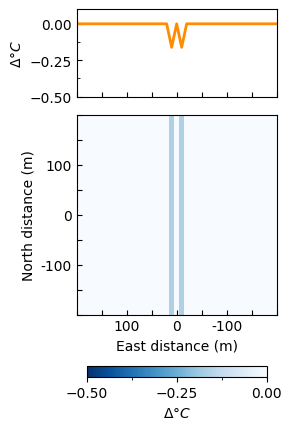

In [117]:
def plot_street_trees(data, vmin=-0.5):

    fig = plt.figure(figsize=(2, 3.5))

    ax = fig.add_axes([0, 0.1333, 1, 0.66])
    img = ax.imshow(data, cmap='Blues_r', vmin=vmin, vmax=0)

    # Adjust ticks
    ax.set_yticks([0, 5, 10, 15, 20, 25, 30, 35, 40])
    ax.set_yticklabels([None,None, -100, None, 0, None, 100, None, None], rotation=0)
    ax.set_xticks([0, 5, 10, 15, 20, 25, 30, 35, 40])
    ax.set_xticklabels([None,None, 100, None, 0, None, -100, None, None])
    ax.tick_params('both', direction='in')
    ax.set_ylabel('North distance (m)')
    ax.set_xlabel('East distance (m)')#, fontfamily='serif')
    ax.set_ylim([0, 40])

    # Create the second figure
    ax2 = fig.add_axes([0, 0.80, 1, 0.25])
    h, w = data.shape
    ax2.sharex(ax)
    ax2.plot(data[h//2, :], linestyle='solid', color='darkorange', linewidth=2, label='$\Delta \degree C$')
    ax2.set_ylabel('$\Delta \degree C$')
    ax2.set_ylim([-0.5, 0.1])
    ax2.set_yticks(np.arange(-0.5, 0, 0.125), minor=True)
    ax2.set_yticks([-0.5, -0.25, 0])
    ax2.tick_params('both', direction='in')
    ax2.tick_params('y', direction='in', which='minor')
    ax2.tick_params(axis='x', labelbottom=False)
    ax2.set_xlim([0, 40])
    
    
    # Create the third figure for the colorbar
    ax3 = fig.add_axes([0.05, 0, 0.9, 0.03])
    cbar = fig.colorbar(img, cax=ax3, orientation='horizontal')
    cbar.ax.set_xticks([-0.5, -0.25, 0])
    cbar.ax.set_xticks(np.arange(-0.5, 0, 0.125), minor=True)
    cbar.set_label('$\Delta \degree C$')

de = calc_direct_effect(street_trees, 'beta_15', 'beta_15_std')
plot_street_trees(de[31:72, 31:72])
# plt.savefig('../results/Figures/street_trees_de.png', dpi=300, bbox_inches='tight')

The direct effect is at a single point. It gets more interesting to look at the indirect effect.

[0.         0.0006527  0.0006527  ... 0.12446097 0.12456861 0.12465675]
-0.436231427491717


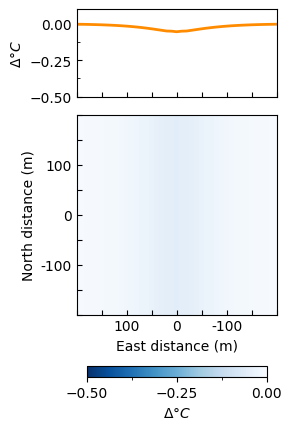

In [131]:
# ie = output*np.mean(df['beta_16']*df['y_std']/ std['beta_16_std'])*5/9
ie = calc_indirect_effect(street_trees, 15, 'beta_16', 'beta_16_std')

plot_street_trees(ie[31:72, 31:72], vmin=-0.5)#, fs=20, plot_left_label=False, plot_right_label=False)
# plt.savefig('../results/Figures/street_trees_ie.png', dpi=300, bbox_inches='tight')

In [97]:
overall = calc_overall(de, ie)

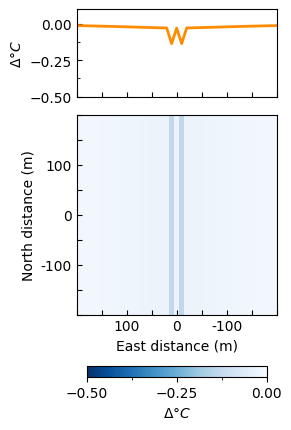

In [98]:
plot_street_trees(overall[31:72, 31:72], vmin=-0.5)#, fs=20, plot_left_label=False)
# plt.savefig('../results/Figures/street_trees_overall.png', dpi=300, bbox_inches='tight')

# Looking at a park

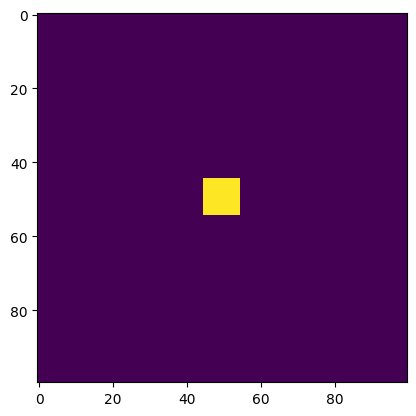

In [99]:
treatment = np.zeros((100, 100))
treatment[45:55, 45:55] = 1
plt.imshow(treatment)
plt.show()

In [100]:
de = calc_direct_effect(treatment, 'beta_15', 'beta_15_std')

<>:22: SyntaxWarning: invalid escape sequence '\D'
<>:23: SyntaxWarning: invalid escape sequence '\D'
<>:37: SyntaxWarning: invalid escape sequence '\D'
<>:22: SyntaxWarning: invalid escape sequence '\D'
<>:23: SyntaxWarning: invalid escape sequence '\D'
<>:37: SyntaxWarning: invalid escape sequence '\D'
C:\Users\esl26\AppData\Local\Temp\ipykernel_26244\2616012572.py:22: SyntaxWarning: invalid escape sequence '\D'
  ax2.plot(data[h//2, :], linestyle='solid', color='darkorange', linewidth=2, label='$\Delta \degree C$')
C:\Users\esl26\AppData\Local\Temp\ipykernel_26244\2616012572.py:23: SyntaxWarning: invalid escape sequence '\D'
  ax2.set_ylabel('$\Delta \degree C$')
C:\Users\esl26\AppData\Local\Temp\ipykernel_26244\2616012572.py:37: SyntaxWarning: invalid escape sequence '\D'
  cbar.set_label('$\Delta \degree C$')


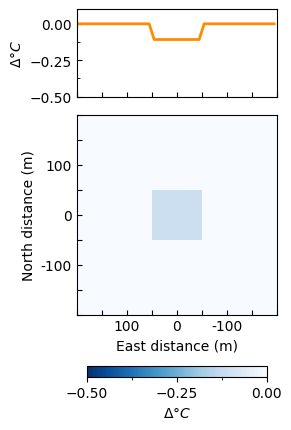

In [102]:
def plot_park(data, vmin=-0.5):
    
    fig = plt.figure(figsize=(2, 3.5))

    ax = fig.add_axes([0, 0.1333, 1, 0.66])
    img = ax.imshow(data, cmap='Blues_r', vmin=vmin, vmax=0)

    ax.set_yticks(np.arange(0.5, 41, 5))
    ax.set_ylim([0.5, 40.5])
    ax.set_yticklabels([None,None, -100, None, 0, None, 100, None, None], rotation=0)
    ax.set_xticks(np.arange(0.5, 41, 5))
    ax.set_xticklabels([None,None, 100, None, 0, None, -100, None, None])
    ax.tick_params('both', direction='in')
    ax.set_ylabel('North distance (m)')
    ax.set_xlabel('East distance (m)')#, fontfamily='serif')
    ax.set_xlim([0.5, 40.5])

    # Create the second figure
    ax2 = fig.add_axes([0, 0.80, 1, 0.25])
    h, w = data.shape
    ax2.sharex(ax)
    ax2.plot(data[h//2, :], linestyle='solid', color='darkorange', linewidth=2, label='$\Delta \degree C$')
    ax2.set_ylabel('$\Delta \degree C$')
    ax2.set_ylim([-0.5, 0.1])
    ax2.set_yticks(np.arange(-0.5, 0, 0.125), minor=True)
    ax2.set_yticks([-0.5, -0.25, 0])
    ax2.tick_params('both', direction='in')
    ax2.tick_params('y', direction='in', which='minor')
    
    ax2.tick_params(axis='x', labelbottom=False)# direction='in')

    # Create third axis for colorbar
    ax3 = fig.add_axes([0.05, 0, 0.9, 0.03])
    cbar = fig.colorbar(img, cax=ax3, orientation='horizontal')
    cbar.ax.set_xticks([-0.5, -0.25, 0])
    cbar.ax.set_xticks(np.arange(-0.5, 0, 0.125), minor=True)
    cbar.set_label('$\Delta \degree C$')


plot_park(de[29:70, 29:70], vmin=-0.5)#, fs=20, plot_right_label=False)
# plt.savefig('../results/Figures/park_de.png', dpi=300, bbox_inches='tight')

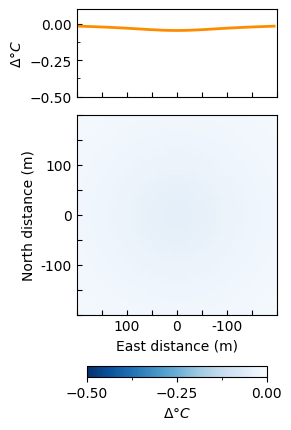

In [103]:
ie = calc_indirect_effect(treatment, 15, 'beta_16', 'beta_16_std')

plot_park(ie[29:70, 29:70], vmin=-0.5)#, fs=20, plot_right_label=False)
# plt.savefig('../results/Figures/park_ie.png', dpi=300, bbox_inches='tight')

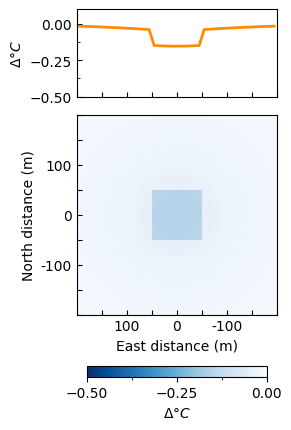

In [104]:
overall = calc_overall(de, ie)
plot_park(overall[29:70, 29:70], vmin=-0.5)#, fs=20, plot_right_label=False)
# plt.savefig('../results/Figures/park_overall.png', dpi=300, bbox_inches='tight')

# Albedo
Let's take a quick look at albedo

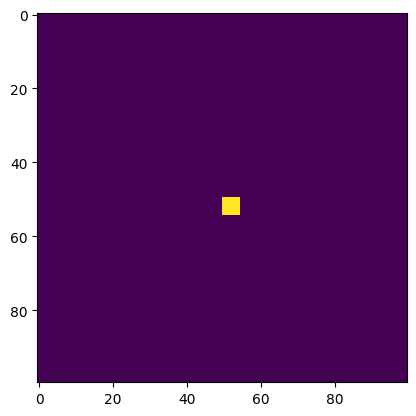

In [105]:
treatment = np.zeros((100, 100))
treatment[50:55, 50:55] = 1
plt.imshow(treatment)

<>:21: SyntaxWarning: invalid escape sequence '\D'
<>:22: SyntaxWarning: invalid escape sequence '\D'
<>:35: SyntaxWarning: invalid escape sequence '\D'
<>:21: SyntaxWarning: invalid escape sequence '\D'
<>:22: SyntaxWarning: invalid escape sequence '\D'
<>:35: SyntaxWarning: invalid escape sequence '\D'
C:\Users\esl26\AppData\Local\Temp\ipykernel_26244\3076830706.py:21: SyntaxWarning: invalid escape sequence '\D'
  ax2.plot(data[h//2, :], linestyle='solid', color='darkorange', linewidth=2, label='$\Delta \degree C$')
C:\Users\esl26\AppData\Local\Temp\ipykernel_26244\3076830706.py:22: SyntaxWarning: invalid escape sequence '\D'
  ax2.set_ylabel('$\Delta \degree C$')
C:\Users\esl26\AppData\Local\Temp\ipykernel_26244\3076830706.py:35: SyntaxWarning: invalid escape sequence '\D'
  cbar.set_label('$\Delta \degree C$')
C:\Users\esl26\AppData\Local\Temp\ipykernel_26244\3076830706.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or u

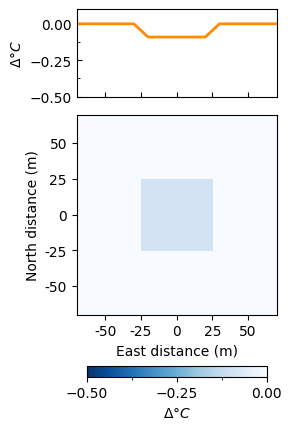

In [106]:
def plot_albedo(data, vmin=-0.5):
    
    fig = plt.figure(figsize=(2, 3.5))

    ax = fig.add_axes([0, 0.1333, 1, 0.66])
    img = ax.imshow(data, cmap='Blues_r', vmin=vmin, vmax=0)

    ax.set_xticklabels([-50, -25, 0, 25, 50])
    ax.set_xticks([2, 4.5, 7, 9.5, 12])
    ax.set_xlim([0., 14])
    ax.set_yticks([2, 4.5, 7, 9.5, 12])
    ax.set_ylim([0., 14])
    ax.set_yticklabels([-50, -25, 0, 25, 50])
    ax.set_ylabel('North distance (m)')
    ax.set_xlabel('East distance (m)')

    # Create the second figure
    ax2 = fig.add_axes([0, 0.80, 1, 0.25])
    h, w = data.shape
    ax2.sharex(ax)
    ax2.plot(data[h//2, :], linestyle='solid', color='darkorange', linewidth=2, label='$\Delta \degree C$')
    ax2.set_ylabel('$\Delta \degree C$')
    ax2.set_ylim([-0.5, 0.1])
    ax2.set_yticks(np.arange(-0.5, 0, 0.125), minor=True)
    ax2.set_yticks([-0.5, -0.25, 0])
    ax2.tick_params('both', direction='in')
    ax2.tick_params('y', direction='in', which='minor')
    ax2.tick_params(axis='x', labelbottom=False)

    # Create third axis for colorbar
    ax3 = fig.add_axes([0.05, 0, 0.9, 0.03])
    cbar = fig.colorbar(img, cax=ax3, orientation='horizontal')
    cbar.ax.set_xticks([-0.5, -0.25, 0])
    cbar.ax.set_xticks(np.arange(-0.5, 0, 0.125), minor=True)
    cbar.set_label('$\Delta \degree C$')


# de = treatment*np.mean(df['beta_17']*df['y_std']/ std['beta_17_std'])*5/9
de = calc_direct_effect(treatment, 'beta_17', 'beta_17_std')
plot_albedo(de[45:60, 45:60], vmin=-0.5)#, fs=20, plot_right_label=False)
# plt.savefig('../results/Figures/albedo_de.png', dpi=300, bbox_inches='tight')

In [107]:
de[45:60, 45:60].shape

(15, 15)

C:\Users\esl26\AppData\Local\Temp\ipykernel_26244\3076830706.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([-50, -25, 0, 25, 50])


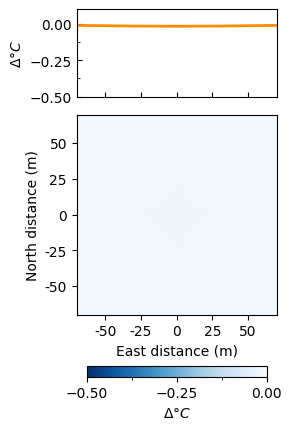

In [123]:
ie = calc_indirect_effect(treatment, 11, 'beta_18', 'beta_18_std')
plot_albedo(ie[45:60, 45:60], vmin=-0.5)#, fs=20, plot_right_label=False)
# plt.savefig('../results/Figures/albedo_ie.png', dpi=300, bbox_inches='tight')
plt.show()

In [109]:
overall = de + ie

C:\Users\esl26\AppData\Local\Temp\ipykernel_26244\3076830706.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([-50, -25, 0, 25, 50])


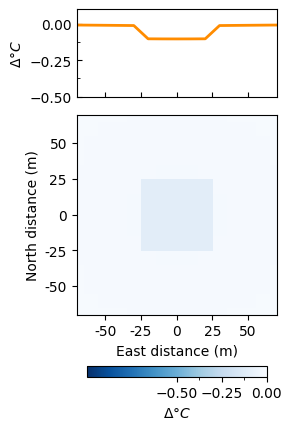

In [110]:

plot_albedo(overall[45:60, 45:60], vmin=-1)

# plt.savefig('../results/Figures/albedo_overall.png', dpi=300, bbox_inches='tight')

plt.show()